In [1]:
# |default_exp dataset

In [2]:
#| export
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader, Batch
import torch
import seaborn as sbn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import KFold
import random
from copy import deepcopy   

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib.pyplot as plt

In [4]:
#| export
def good_luck():
    return True

In [5]:
# |export 
class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        buckets = [[]] * 100
        yielded = 0

        for idx in self.sampler:
            s = self.sampler.data_source[idx]
            if isinstance(s,tuple): L = s[0]["mask"].sum()
            else: L = s["mask"].sum()
            L = max(1,L // 16) 
            if len(buckets[L]) == 0:  buckets[L] = []
            buckets[L].append(idx)
            
            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []
                
        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch
            
def dict_to(x, device='cuda'):
    return {k:x[k].to(device) for k in x}

def to_device(x, device='cuda'):
    return tuple(dict_to(e,device) for e in x)

class DeviceDataLoader:
    def __init__(self, dataloader, device='cuda'):
        self.dataloader = dataloader
        self.device = device
    
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        for batch in self.dataloader:
            yield tuple(dict_to(x, self.device) for x in batch)

In [6]:
# |export
def encode_rna_sequence(seq):
    L = len(seq)

    # Initialize the tensor with zeros
    tensor = np.zeros((L, L, 8))

    # Define valid base pairs
    valid_pairs = [
        ("A", "U"),
        ("U", "A"),
        ("U", "G"),
        ("G", "U"),
        ("G", "C"),
        ("C", "G"),
    ]

    for i in range(L):
        for j in range(L):
            # Check for valid base pairs
            if (seq[i], seq[j]) in valid_pairs:
                channel = valid_pairs.index((seq[i], seq[j]))
                tensor[i, j, channel] = 1
            # Check for diagonal
            elif i == j:
                tensor[i, j, 6] = 1
            # If not a valid pair and not on the diagonal, set the last channel
            else:
                tensor[i, j, 7] = 1

    return tensor


def generate_edge_data(file_path):
    # Read the file into a DataFrame
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])

    # Convert the pos1 and pos2 columns to 0-based indices and then to a tensor for edge index
    edge_index = torch.tensor(
        [data["pos1"].values - 1, data["pos2"].values - 1], dtype=torch.long
    )

    # Convert the prob column to a tensor for edge features
    edge_features = torch.tensor(data["prob"].values, dtype=torch.float).unsqueeze(
        1
    )  # Adding an extra dimension

    return edge_index, edge_features


class RNA_DatasetBaseline(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"]
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"]

        split = list(
            KFold(n_splits=nfolds, random_state=seed, shuffle=True).split(df_2A3)
        )[fold][0 if mode == "train" else 1]
        df_2A3 = df_2A3.iloc[split].reset_index(drop=True)
        df_DMS = df_DMS.iloc[split].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


class RNA_DatasetBaselineSplit(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


class RNA_DatasetBaseline(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"]
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"]

        split = list(
            KFold(n_splits=nfolds, random_state=seed, shuffle=True).split(df_2A3)
        )[fold][0 if mode == "train" else 1]
        df_2A3 = df_2A3.iloc[split].reset_index(drop=True)
        df_DMS = df_DMS.iloc[split].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


class RNA_DatasetV0(Dataset):
    def __init__(self, df, mask_only=False, prob_for_adj=0.5, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        self.prob_for_adj = prob_for_adj
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.bpp = df_2A3["bpp"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        adj_matrix = generate_adj_matrix(self.bpp[idx], self.Lmax, self.prob_for_adj)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": adj_matrix}, {
            "react": react,
            "react_err": react_err,
            "mask": mask,
        }


class RNA_DatasetV1(Dataset):
    # same as v0 but not adj matrix
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.bpp = df_2A3["bpp"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        return {"seq": torch.from_numpy(seq), "mask": mask}, {
            "react": react,
            "react_err": react_err,
            "mask": mask,
        }


class RNA_DatasetV0G(Dataset):
    def __init__(self, df, path_to_bpp_folder, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.L = df_2A3["L"].values

        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.bpp = df_2A3["bpp"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        edge_index, edge_features = generate_edge_data(self.bpp[idx])
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        return Data(
            x=torch.from_numpy(seq),
            edge_index=edge_index,
            edge_features=edge_features,
            y=react,
            y_err=react_err,
        )


class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        buckets = [[]] * 100
        yielded = 0

        for idx in self.sampler:
            s = self.sampler.data_source[idx]
            if isinstance(s, tuple):
                L = s[0]["mask"].sum()
            else:
                L = s["mask"].sum()
            L = max(1, L // 16)
            if len(buckets[L]) == 0:
                buckets[L] = []
            buckets[L].append(idx)

            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []

        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch


def generate_base_pair_matrix(file_path, L):
    """
    Reads a TXT file of base pair probabilities and generates an n x n matrix.

    Args:
    - file_path (str): Path to the TXT file.

    Returns:
    - np.array: An n x n matrix of base pair probabilities.
    """
    # Read the data using pandas
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])

    # Find the largest position in the 'pos1' column
    largest_position = data["pos1"].max()

    ids = torch.from_numpy(data[["pos1", "pos2"]].values)
    matrix = torch.zeros((L, L))
    matrix[ids[:, 0] - 1, ids[:, 1] - 1] = torch.from_numpy(data["prob"].values).float()
    matrix[ids[:, 1] - 1, ids[:, 0] - 1] = torch.from_numpy(data["prob"].values).float()

    matrix[:26, :] = 0
    matrix[:, :26] = 0

    # Adjust the end based on the largest_position and set the last 21 positions to 0
    adjusted_end = largest_position - 21
    matrix[adjusted_end:, :] = 0
    matrix[:, adjusted_end:] = 0

    return matrix


class RNA_DatasetBaselineSplitbppV0(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.bpp = df_2A3["bpp"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        bpp = (generate_base_pair_matrix(self.bpp[idx], self.Lmax) > 0.5).int()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


def generate_base_pair_matrixv1(file_path, L):
    """
    Reads a TXT file of base pair probabilities and generates an n x n matrix.

    Args:
    - file_path (str): Path to the TXT file.

    Returns:
    - np.array: An n x n matrix of base pair probabilities.
    """
    # Read the data using pandas
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])

    # Find the largest position in the 'pos1' column
    largest_position = data["pos1"].max()

    ids = torch.from_numpy(data[["pos1", "pos2"]].values.astype(int))
    matrix = torch.zeros((L, L))
    matrix[ids[:, 0] - 1, ids[:, 1] - 1] = torch.from_numpy(data["prob"].values).float()
    matrix[ids[:, 1] - 1, ids[:, 0] - 1] = torch.from_numpy(data["prob"].values).float()

    return matrix


class RNA_DatasetBaselineSplitbppV1(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.bpp = df_2A3["bpp"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        bpp = (generate_base_pair_matrixv1(self.bpp[idx], self.Lmax) > 0.5).int()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


def dot_to_adjacency(dot_notation, n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    dot_notation = (26 * ".") + dot_notation + (21 * ".")
    stack = []
    for i, char in enumerate(dot_notation):
        if char == "(":
            stack.append(i)
        elif char == ")":
            j = stack.pop()
            adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1

    return adjacency_matrix


class RNA_DatasetBaselineSplitssV0(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_roi"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


class RNA_DatasetBaselineSplitssV0(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_roi"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


class RNA_DatasetBaselineSplitssV1(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.ss_map = {".": 0, "(": 1, ")": 2}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)

        ss_seq = [self.ss_map[s] for s in self.ss[idx]]
        ss_seq = np.array(ss_seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_seq = np.pad(ss_seq, (0, self.Lmax - len(ss_seq)))

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_seq": torch.from_numpy(ss_seq),
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitbppV2(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}

        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.seq = df_2A3["sequence"].values
        self.bpp = df_2A3["bpp"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)

        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {"seq": torch.from_numpy(seq), "mask": mask, "bpp": bpp}, {
            "react": react,
            "react_err": react_err,
            "sn": sn,
            "mask": mask,
        }


def dot_to_adjacencyv0(dot_notation, n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    stack = []
    for i, char in enumerate(dot_notation):
        if char == "(":
            stack.append(i)
        elif char == ")":
            j = stack.pop()
            adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1

    return adjacency_matrix


class RNA_DatasetBaselineSplitssbppV0Conv(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq_holder = np.zeros(self.Lmax, dtype=int)
        seq_holder[: len(seq)] = seq

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return deepcopy(
            {
                "seq": torch.from_numpy(seq_holder),
                "mask": mask,
            }
        ), {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV0(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = (generate_base_pair_matrixv1(self.bpp[idx], self.Lmax) > 0.5).int()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "adj_matrix": bpp,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV1(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


def load_rnafm(filename, seq_len, L_max):
    """
    Load data from a .npy file and convert it to an N x N matrix.

    Parameters:
    - filename: Path to the .npy file.
    - N: Dimension of the square matrix.

    Returns:
    - bpp_matrix: N x N matrix reconstructed from the input file.
    """
    # Load the structured array from the .npy file
    data = np.load(filename)

    # Create an empty N x N matrix
    bpp_matrix = np.zeros((seq_len, seq_len))

    # Fill the matrix with the probabilities from the loaded data
    bpp_matrix[data["pos_1"], data["pos_2"]] = data["probabilities"]

    bpp_matrix = bpp_matrix + bpp_matrix.T - np.diag(np.diag(bpp_matrix))
    full = np.zeros((L_max, L_max))
    full[:seq_len, :seq_len] = bpp_matrix
    return torch.tensor(full)


def extra_bpp_from_numpy(filename, N, seq_len=None):
    """
    Load data from a .npy file and convert it to an N x N matrix.

    Parameters:
    - filename: Path to the .npy file.
    - N: Dimension of the square matrix.

    Returns:
    - bpp_matrix: N x N matrix reconstructed from the input file.
    """
    # Load the structured array from the .npy file
    if filename.parent.stem in ["rnafm", "rnaformerv1"]:
        full = load_rnafm(filename, seq_len, N)
    else:
        data = np.load(filename)
        # Create an empty N x N matrix
        bpp_matrix = np.zeros((N, N))
        # Fill the matrix with the probabilities from the loaded data
        bpp_matrix[data["pos_1"], data["pos_2"]] = data["probabilities"]
        full = torch.tensor(bpp_matrix)

    return full


class RNA_DatasetBaselineSplitssbppV1R(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["rnafm"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only

        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy",
                self.Lmax,
                seq_len=len(self.seq[idx]),
            )
            for i in self.extra_bpp
        ]
        bpp = torch.stack([*bpp_extra, bpp], dim=0).mean(0).float()
        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV2(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy", self.Lmax
            )
            for i in self.extra_bpp
        ]
        bpp = torch.stack([bpp, *bpp_extra], dim=0).mean(0).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV3(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2", "rnaformer"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax).float()
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy",
                self.Lmax,
                seq_len=len(self.seq[idx]),
            )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
            "bb_matrix_full_prob_extra": bpp_extra,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV4(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["rnafm"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax).float()
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy",
                self.Lmax,
                seq_len=len(self.seq[idx]),
            )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
            "bb_matrix_full_prob_extra": bpp_extra,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV5(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["rnafm", "vienna_2", "contrafold_2", "rnaformer"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = np.pad(seq, (0, self.Lmax - len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax).float()
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy",
                self.Lmax,
                seq_len=len(self.seq[idx]),
            )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return deepcopy(
            {
                "seq": torch.from_numpy(seq),
                "mask": mask,
                "ss_adj": ss_adj,
                "bb_matrix_full_prob": bpp,
                "bb_matrix_full_prob_extra": bpp_extra,
            }
        ), {"react": react, "react_err": react_err, "sn": sn, "mask": mask}


class RNA_DatasetBaselineSplitssbppV6(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2", "rnaformerv1"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq_holder = np.zeros(self.Lmax, dtype=int)
        seq_holder[: len(seq)] = seq

        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax).float()
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy",
                self.Lmax,
                seq_len=len(self.seq[idx]),
            )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return deepcopy(
            {
                "seq": torch.from_numpy(seq_holder),
                "mask": mask,
                "ss_adj": ss_adj,
                "bb_matrix_full_prob": bpp,
                "bb_matrix_full_prob_extra": bpp_extra,
            }
        ), deepcopy({"react": react, "react_err": react_err, "sn": sn, "mask": mask})




class RNA_DatasetBaselineFM(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"S": 0, "E": 2, "A": 4, "U": 7, "C": 5, "G": 6}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}

        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[: len(seq)] = True
        seq = [self.seq_map[s] for s in "S" + seq + "E"]
        seq = np.array(seq)
        seq_holder = np.ones(self.Lmax + 2, dtype=int)
        seq_holder[: len(seq)] = seq

        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax).float()

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        return {
            "seq": torch.from_numpy(seq_holder).long(),
            "mask": mask,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bpp,
        }, {"react": react, "react_err": react_err, "sn": sn, "mask": mask}
        

class RNA_DatasetBaselineSplitssbppV7Flip(Dataset):
    def __init__(
        self,
        df,
        mode="train",
        seed=2023,
        fold=0,
        nfolds=4,
        mask_only=False,
        sn_train=True,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2", "rnaformerv1"],
        **kwargs,
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)

        if mode != "train" or sn_train:
            m = (df_2A3["SN_filter"].values > 0) & (df_DMS["SN_filter"].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)

        self.bpp = df_2A3["bpp"].values
        self.seq = df_2A3["sequence"].values
        self.ss = df_2A3["ss_full"].values
        self.L = df_2A3["L"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path
        self.mode = mode

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        seq = self.seq[idx]
        L = len(seq)
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[: len(seq)] = True
            return {"mask": mask}, {"mask": mask}

        seq0 = np.array([*seq])
        seq = np.zeros(L, dtype=np.int64)
        for k in self.seq_map:
            seq[seq0 == k] = self.seq_map[k]
        seq = torch.from_numpy(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:L] = True

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )
        if react.shape[0] != self.Lmax:
            react = F.pad(react, (0, 0, 0, self.Lmax - react.shape[0]), value=torch.nan)
            react_err = F.pad(
                react_err, (0, 0, 0, self.Lmax - react_err.shape[0]), value=torch.nan
            )

        sn = torch.FloatTensor([self.sn_2A3[idx], self.sn_DMS[idx]])

        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], L)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], L).float()
        
        e_bpp = self.extra_bpp
        if self.mode == "train" and random.random() > 0.5:
            e_bpp = e_bpp + ["rnafm"]
               
        bpp_extra = [
            extra_bpp_from_numpy(
                self.extra_bpp_path / f"{i}/{self.bpp[idx].stem}.npy", L, seq_len=L
            )
            for i in e_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()

        if self.mode == "train" and random.random() > 0.5:
            seq = seq.flip(-1)
            bpp = bpp.flip(-1, -2)
            bpp_extra = bpp_extra.flip(-1, -2)
            ss_adj = ss_adj.flip(-1, -2)

            react = F.pad(react[:L].flip(0), (0, 0, 0, self.Lmax - L), value=torch.nan)
            react_err = F.pad(
                react_err[:L].flip(0), (0, 0, 0, self.Lmax - L), value=torch.nan
            )

        seq = F.pad(seq, (0, self.Lmax - L))
        bpp = F.pad(bpp, (0, self.Lmax - L, 0, self.Lmax - L))
        bpp_extra = F.pad(bpp_extra, (0, self.Lmax - L, 0, self.Lmax - L))
        ss_adj = F.pad(ss_adj, (0, self.Lmax - L, 0, self.Lmax - L))

        return deepcopy(
            {
                "seq": seq,
                "mask": mask,
                "ss_adj": ss_adj,
                "bb_matrix_full_prob": bpp,
                "bb_matrix_full_prob_extra": bpp_extra,
            }
        ), deepcopy({"react": react, "react_err": react_err, "sn": sn, "mask": mask})

In [7]:
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 16
#     num_workers = 8
#     device = 'cpu'
#     adjnact_prob = 0.5
    


# fns = list(CFG.pathbb.rglob("*.txt"))
# bpp_df = pd.DataFrame({"bpp": fns})
# bpp_df['sequence_id'] = bpp_df['bpp'].apply(lambda x: x.stem)
# ss = pd.read_parquet(CFG.pathss)[["sequence_id", "ss_full"]]
# df = pd.read_parquet(CFG.path/'train_data.parquet')
# split = pd.read_csv(CFG.split_id)
# df = pd.merge(df, split, on='sequence_id')
# df = pd.merge(df, bpp_df, on='sequence_id')
# df = pd.merge(df, ss, on='sequence_id')
# df_train = df.query('is_train==True').reset_index(drop=True)
# df_valid = df.query('is_train==False').reset_index(drop=True)
# ds_val = RNA_DatasetBaselineSplitssbppV7Flip(df_valid, mode='train')
# ds_val_len = RNA_DatasetBaselineSplitssbppV7Flip(df_valid, mode='eval', mask_only=True)
# sampler_val = torch.utils.data.SequentialSampler(ds_val_len)
# len_sampler_val = LenMatchBatchSampler(sampler_val, batch_size=CFG.bs, 
#                drop_last=False)
# dl_val= DeviceDataLoader(torch.utils.data.DataLoader(ds_val, 
#                batch_sampler=len_sampler_val, num_workers=CFG.num_workers), CFG.device)




In [8]:
# | export
class RNA_Dataset_Test(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)

        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)

        return {"seq": torch.from_numpy(seq), "mask": mask}, {"ids": ids}


class RNA_Dataset_TestBpp(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp = (generate_base_pair_matrix(bpp, self.Lmax) > 0.5).int()

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "ids": ids
        }


class RNA_Dataset_Testss(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only
        self.ss = df["ss_roi"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()

        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": bpp}, {
            "ids": ids
        }


class RNA_Dataset_TestBppSS(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp = (generate_base_pair_matrix(bpp, self.Lmax) > 0.5).int()
        ss_adj = torch.tensor(dot_to_adjacency(self.df["ss_roi"][idx], self.Lmax)).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
        }, {"ids": ids}


class RNA_Dataset_TestBppSSFullV0(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bb_matrix_full_prob = generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(
            dot_to_adjacencyv0(self.df["ss_full"][idx], self.Lmax)
        ).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bb_matrix_full_prob,
        }, {"ids": ids}


class RNA_Dataset_TestBppSSFullV1(Dataset):
    def __init__(
        self,
        df,
        mask_only=False,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2"],
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp_ = generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(self.extra_bpp_path / f"{i}/{bpp.stem}.npy", self.Lmax)
            for i in self.extra_bpp
        ]
        bb_matrix_full_prob = torch.stack([bpp_, *bpp_extra], dim=0).mean(0).float()

        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(
            dot_to_adjacencyv0(self.df["ss_full"][idx], self.Lmax)
        ).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bb_matrix_full_prob,
        }, {"ids": ids}
        
        
class RNA_Dataset_TestBppSSFullV2(Dataset):
    def __init__(
        self,
        df,
        mask_only=False,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["vienna_2", "contrafold_2", "rnaformer"],
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp_ = generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(self.extra_bpp_path / f"{i}/{bpp.stem}.npy", self.Lmax, seq_len=L )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()
        bb_matrix_full_prob = bpp_.float()

        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(
            dot_to_adjacencyv0(self.df["ss_full"][idx], self.Lmax)
        ).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bb_matrix_full_prob,
            "bb_matrix_full_prob_extra": bpp_extra,
        }, {"ids": ids}
        
class RNA_Dataset_TestBppSSFullV3(Dataset):
    def __init__(
        self,
        df,
        mask_only=False,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["rnafm"],
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp_ = generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(self.extra_bpp_path / f"{i}/{bpp.stem}.npy", self.Lmax, seq_len=L )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()
        bb_matrix_full_prob = bpp_.float()

        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(
            dot_to_adjacencyv0(self.df["ss_full"][idx], self.Lmax)
        ).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bb_matrix_full_prob,
            "bb_matrix_full_prob_extra": bpp_extra,
        }, {"ids": ids}
        
        
        

class RNA_Dataset_TestBppSSFullV4(Dataset):
    def __init__(
        self,
        df,
        mask_only=False,
        extra_bpp_path=Path("../eda/bpp"),
        extra_bpp=["rnafm", "vienna_2", "contrafold_2", "rnaformer"],
        **kwargs,
    ):
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        df["L"] = df.sequence.apply(len)
        self.Lmax = df["L"].max()
        self.df = df
        self.mask_only = mask_only
        self.extra_bpp = extra_bpp
        self.extra_bpp_path = extra_bpp_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ["id_min", "id_max", "sequence"]]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only:
            return {"mask": mask}, {}
        ids = np.arange(id_min, id_max + 1)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq, (0, self.Lmax - L))
        ids = np.pad(ids, (0, self.Lmax - L), constant_values=-1)
        bpp = self.df["bpp"][idx]
        bpp_ = generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp_extra = [
            extra_bpp_from_numpy(self.extra_bpp_path / f"{i}/{bpp.stem}.npy", self.Lmax, seq_len=L )
            for i in self.extra_bpp
        ]
        bpp_extra = torch.stack([*bpp_extra], dim=0).mean(0).float()
        bb_matrix_full_prob = bpp_.float()

        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(
            dot_to_adjacencyv0(self.df["ss_full"][idx], self.Lmax)
        ).int()

        return {
            "seq": torch.from_numpy(seq),
            "mask": mask,
            "adj_matrix": bpp,
            "ss_adj": ss_adj,
            "bb_matrix_full_prob": bb_matrix_full_prob,
            "bb_matrix_full_prob_extra": bpp_extra,
        }, {"ids": ids}
        


In [9]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [12]:
import os
class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV4' #"RNA_Dataset_TestBppSSFullV1" #'RNA_Dataset_TestBppSSFullV0' #`RNA_Dataset_TestBppSS' #'
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/test_ss_vienna_rna.parquet")
    bs = 256
    num_workers = 16
    device = 'cuda'
    
def plot_test_example(fn):
    import polars as pl
    import matplotlib.pyplot as plt
    #read your sub here
    df=pl.read_parquet(f"{fn}.parquet")
    #some parameters
    font_size=6
    id1=269545321
    id2=269724007
    reshape1=391
    reshape2=457
    #get predictions
    pred_DMS=df[id1:id2+1]['reactivity_DMS_MaP'].to_numpy().reshape(reshape1,reshape2)
    pred_2A3=df[id1:id2+1]['reactivity_2A3_MaP'].to_numpy().reshape(reshape1,reshape2)
    #plot mutate and map
    fig = plt.figure()
    plt.subplot(121)
    plt.title(f'reactivity_DMS_MaP', fontsize=font_size)
    plt.imshow(pred_DMS,vmin=0,vmax=1, cmap='gray_r')
    plt.subplot(122)
    plt.title(f'reactivity_2A3_MaP', fontsize=font_size)
    plt.imshow(pred_2A3,vmin=0,vmax=1, cmap='gray_r')
    plt.tight_layout()
    plt.savefig(f"plot.png",dpi=500)
    plt.clf()
    plt.close()

df_test = pd.read_csv(os.path.join('../data/','test_sequences.csv'))
print(df_test.shape)
fns = list(CFG_test.pathbb.rglob("*.txt"))
bpp_df = pd.DataFrame({"bpp": fns})
bpp_df['sequence_id'] = bpp_df['bpp'].apply(lambda x: x.stem)
print(df_test.shape)
bpp_df.drop_duplicates(subset=['sequence_id'], inplace=True)
ss = pd.read_parquet(CFG_test.pathss)[["sequence_id", "ss_roi", "ss_full"]]
print(df_test.shape)
df_test = pd.merge(df_test, bpp_df, on='sequence_id')
print(df_test.shape)
df_test = pd.merge(df_test, ss, on='sequence_id')
print(df_test.shape)

(1343823, 5)
(1343823, 5)
(1343823, 5)
(1343823, 6)
(1343823, 8)


In [13]:
df_test["L"] = df_test["sequence"].map(len)
df_test = df_test.query('L>250').reset_index(drop=True)
extra_bpp=["rnafm", "vienna_2", "contrafold_2", "rnaformerv1"]
extra_bpp_path=Path("../eda/bpp")

In [14]:
idx = -80
row = df_test.iloc[idx]

In [15]:
bpp_extra = [
            extra_bpp_from_numpy(extra_bpp_path / f"{i}/{row.bpp.stem}.npy", row.L, seq_len=row.L)
            for i in extra_bpp
        ]

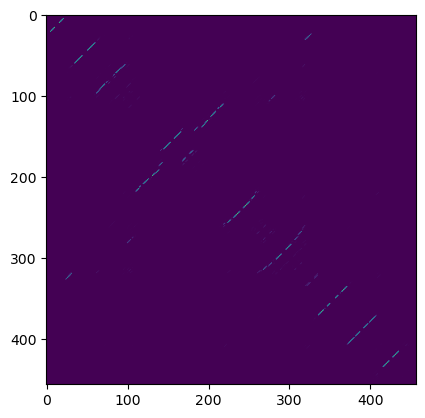

__


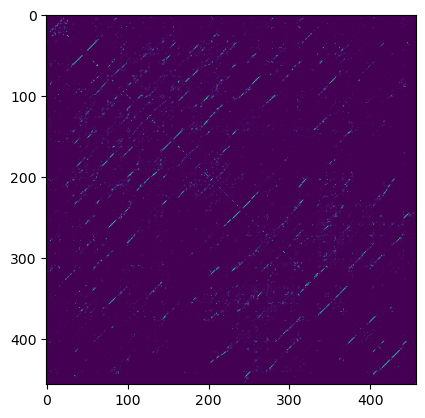

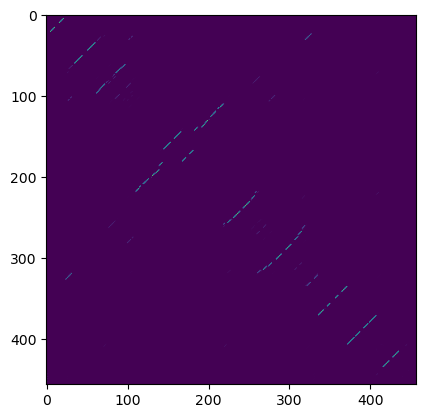

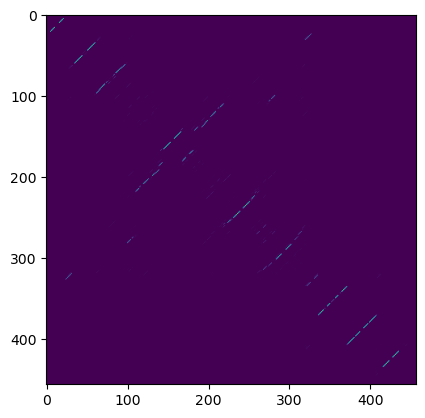

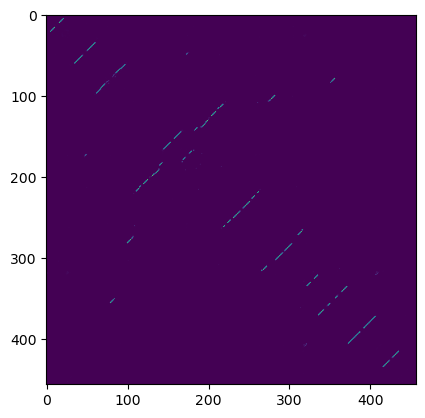

In [16]:
plt.imshow(generate_base_pair_matrixv1(row['bpp'], row.L))
plt.pause(0.1)
print('__')
for i in bpp_extra:
    plt.imshow(i)
    plt.show()

In [17]:
for i in extra_bpp:
    print(f"{i}/{row.bpp.stem}.npy")
    

rnafm/56ad1cb16895.npy
vienna_2/56ad1cb16895.npy
contrafold_2/56ad1cb16895.npy
rnaformerv1/56ad1cb16895.npy


In [18]:
np.load('../eda/bpp/rnaformerv1/eb9bd6372550.npy')[0][0].dtype

dtype('int64')

In [19]:
bpp_extra[-1]

tensor([[0.0000, 0.0006, 0.0007,  ..., 0.0013, 0.0015, 0.0042],
        [0.0006, 0.0000, 0.0014,  ..., 0.0014, 0.0025, 0.0031],
        [0.0007, 0.0014, 0.0000,  ..., 0.0031, 0.0016, 0.0018],
        ...,
        [0.0013, 0.0014, 0.0031,  ..., 0.0000, 0.0011, 0.0020],
        [0.0015, 0.0025, 0.0016,  ..., 0.0011, 0.0000, 0.0009],
        [0.0042, 0.0031, 0.0018,  ..., 0.0020, 0.0009, 0.0000]],
       dtype=torch.float64)